In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

## training yolov8 with dogs and cats dataset

https://www.kaggle.com/datasets/andrewmvd/dog-and-cat-detection

#### use kaggle api to download dataset

#### upload kaggle api token to ``` ~/.kaggle/kaggle.json ```

In [2]:
# kaggle dowload if upload dataset skip this
!pip install --user kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/kaggle.json
!kaggle datasets download -d andrewmvd/dog-and-cat-detection

100% 1.02G/1.03G [00:36<00:00, 39.7MB/s]
100% 1.03G/1.03G [00:36<00:00, 30.3MB/s]


In [ ]:
!unzip ./dog-and-cat-detection.zip

In [4]:
yolo_class = {
    0 : "dog",
    1 : "cat"
}

### Convert Pascal VOC XML to Yolo txt

In [5]:
import xml.etree.ElementTree as ET
from tqdm import tqdm
from pathlib import Path
import shutil

def convert_label(path, lb_path):
  def convert_box(size, box):
    dw, dh = 1. / size[0], 1. / size[1]
    x, y, w, h = (box[0] + box[1]) / 2.0 - 1, (box[2] + box[3]) / 2.0 - 1, box[1] - box[0], box[3] - box[2]
    return x * dw, y * dh, w * dw, h * dh

  in_file = open(path)
  out_file = open(lb_path, 'w')
  tree = ET.parse(in_file)
  root = tree.getroot()
  size = root.find('size')
  w = int(size.find('width').text)
  h = int(size.find('height').text)

  names = [yolo_class[0] , yolo_class[1]] # names list
  for obj in root.iter('object'):
    cls = obj.find('name').text
    if cls in names and int(obj.find('difficult').text) != 1:
      xmlbox = obj.find('bndbox')
      bb = convert_box((w, h), [float(xmlbox.find(x).text) for x in ('xmin', 'xmax', 'ymin', 'ymax')])
      cls_id = names.index(cls)  # class id
      out_file.write(" ".join([str(a) for a in (cls_id, *bb)]) + '\n')




In [6]:
path = Path("./yolo")

for dir in ("train" , "valid"):
  imgs_path = path / dir / 'images'
  lbs_path = path / dir / 'labels'
  imgs_path.mkdir(exist_ok=True, parents=True)
  lbs_path.mkdir(exist_ok=True, parents=True)

train_valid_ratio = 0.9
annotations = list(Path("./annotations/").glob("*.xml"))
for idx , an_path in enumerate(annotations):
  target_lb_path = path / 'train' / 'labels' if idx < train_valid_ratio * len(annotations) else path / 'valid' / 'labels'
  target_img_path = path / 'train' / 'images' if idx < train_valid_ratio * len(annotations) else path / 'valid' / 'images'
  lb_path = (target_lb_path / an_path.name).with_suffix('.txt')  # new label path
  shutil.copy( (Path("./images") / an_path.name).with_suffix('.png') , target_img_path)
  convert_label(an_path, lb_path)  # convert labels to YOLO format

### yolo train yaml

In [7]:
yaml_file = """
path: /content/yolo
train: train/images
val: valid/images

names:
 0: dog
 1: cat
"""
with open("dog_cat.yaml" , 'w') as f:
  f.write(yaml_file)


In [8]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.0/605.0 kB 8.1 MB/s eta 0:00:00


#### CLI

In [16]:
!yolo detect train data=dog_cat.yaml model=yolov8n.pt epochs=10 imgsz=320

Ultralytics YOLOv8.0.143 🚀 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=dog_cat.yaml, epochs=10, patience=50, batch=16, imgsz=320, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=Fa

#### python test

In [ ]:
from ultralytics import YOLO
model = YOLO('/content/runs/detect/train2/weights/best.pt')
model.predict("/content/yolo/valid/images/Cats_Test1001.png", save=True, imgsz=320, conf=0.5)

## export yolov8 to trt

In [21]:
# your model path
train_path = Path("/content/runs/detect/train2")
model_path = train_path / "weights"
pt_file = str(model_path / "best.pt")
onnx_file = str(model_path / "best.onnx")
trt_file = str(model_path / "best.engine")

In [22]:
# from google.colab import files
# files.download(train_path / "results.png")

In [23]:
!yolo export model={pt_file} format=onnx

Ultralytics YOLOv8.0.143 🚀 Python-3.10.6 torch-2.0.1+cu118 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients

PyTorch: starting from '/content/runs/detect/train2/weights/best.pt' with input shape (1, 3, 320, 320) BCHW and output shape(s) (1, 6, 2100) (5.9 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 103.5 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 7.2s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.14.0 opset 17...
============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

ONNX: export success ✅ 8.0s, saved as '/content/runs/detect/train2/weights/best.onnx' (11.6 MB)

Export complete (

In [24]:
from google.colab import files
files.download(onnx_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### onnx to trt engine

In [25]:
!python3 -m pip install --upgrade tensorrt

  Preparing metadata (setup.py) ... done
  Created wheel for tensorrt: filename=tensorrt-8.6.1-py2.py3-none-any.whl size=16972 sha256=5d887cf9a79106206912e055dab94fdc96c8119b88550dd55363b5400ce53bab
  Stored in directory: /root/.cache/pip/wheels/6d/29/56/abdffd4c604f255b5254bef3f1c598ab7811ea020540599438
Successfully built tensorrt


In [26]:
import tensorrt as trt

TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
trt_runtime = trt.Runtime(TRT_LOGGER)
def build_engine(onnx_path, shape):

   """
   This is the function to create the TensorRT engine
   Args:
      onnx_path : Path to onnx_file.
      shape : Shape of the input of the ONNX file.
  """
   with trt.Builder(TRT_LOGGER) as builder, builder.create_network(1) as network, builder.create_builder_config() as config, trt.OnnxParser(network, TRT_LOGGER) as parser:
       config.max_workspace_size = (256 << 20)
       with open(onnx_path, 'rb') as model:
           parser.parse(model.read())
       network.get_input(0).shape = shape
       engine = builder.build_engine(network, config)
       return engine

def save_engine(engine, file_name):
   buf = engine.serialize()
   with open(file_name, 'wb') as f:
       f.write(buf)
def load_engine(trt_runtime, plan_path):
  with open(plan_path, 'rb') as f:
    engine_data = f.read()
  engine = trt_runtime.deserialize_cuda_engine(engine_data)
  # engine = trt_runtime.deserialize_cuda_engine(Path(plan_path).read_bytes())
  return engine

In [27]:
import argparse
from onnx import ModelProto
import tensorrt as trt

engine_name = trt_file
onnx_path = onnx_file

batch_size = 1

model = ModelProto()
with open(onnx_path, "rb") as f:
    model.ParseFromString(f.read())

d0 = model.graph.input[0].type.tensor_type.shape.dim[1].dim_value
d1 = model.graph.input[0].type.tensor_type.shape.dim[2].dim_value
d2 = model.graph.input[0].type.tensor_type.shape.dim[3].dim_value
shape = [batch_size , d0, d1 ,d2]
engine = build_engine(onnx_path, shape= shape)
save_engine(engine, engine_name)

<ipython-input-26-3bf4ff76d973>:14: DeprecationWarning: Use set_memory_pool_limit instead.
  config.max_workspace_size = (256 << 20)
<ipython-input-26-3bf4ff76d973>:18: DeprecationWarning: Use build_serialized_network instead.
  engine = builder.build_engine(network, config)


In [28]:
output_0 = model.graph.output[0].type.tensor_type.shape.dim[0].dim_value
output_1 = model.graph.output[0].type.tensor_type.shape.dim[1].dim_value
output_2 = model.graph.output[0].type.tensor_type.shape.dim[2].dim_value
model_output_shape = (output_0 , output_1 , output_2)
print(model_output_shape)

(1, 6, 2100)


## tensorRT inference yolov8 engine

In [29]:
!pip install pycuda
!wget https://www.akc.org/wp-content/uploads/2021/07/Cavalier-King-Charles-Spaniel-laying-down-indoors.jpeg -O ./dog.jpeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.6 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2022.2.2-cp310-cp310-linux_x86_64.whl size=661405 sha256=363882dae1c0da03945c7d3d6eeeb0cc133a0623eba312b7d47f3a73d730fa12
  Stored in directory: /root/.cache/pip/wheels/1d/7b/06/82a395a243fce00035dea9914d92bbef0013401497d849f8bc
Successfully built pycuda
--2023-07-27 06:22:44--  https://www.akc.org/wp-content/uploads/2021/07/Cavalier-King-Charles-Spaniel-laying-down-indoors.jpeg
Resolving www.akc.org (www.akc.org)... 151.101.2.133, 151.101.66.133, 151.101.130.133, ...
Connecting to www.akc.org (www.akc.org)|151.101.2.133|:443... connected.
HTTP request sent, awaiting respons

In [30]:
import tensorrt as trt
import pycuda.driver as cuda
import numpy as np
import pycuda.autoinit

def allocate_buffers(engine, batch_size, data_type):

   """
   This is the function to allocate buffers for input and output in the device
   Args:
      engine : The path to the TensorRT engine.
      batch_size : The batch size for execution time.
      data_type: The type of the data for input and output, for example trt.float32.

   Output:
      h_input_1: Input in the host.
      d_input_1: Input in the device.
      h_output_1: Output in the host.
      d_output_1: Output in the device.
      stream: CUDA stream.

   """

   # Determine dimensions and create page-locked memory buffers (which won't be swapped to disk) to hold host inputs/outputs.
   h_input_1 = cuda.pagelocked_empty(batch_size * trt.volume(engine.get_binding_shape(0)), dtype=trt.nptype(data_type))
   h_output = cuda.pagelocked_empty(batch_size * trt.volume(engine.get_binding_shape(1)), dtype=trt.nptype(data_type))
   # Allocate device memory for inputs and outputs.
   d_input_1 = cuda.mem_alloc(h_input_1.nbytes)

   d_output = cuda.mem_alloc(h_output.nbytes)
   # Create a stream in which to copy inputs/outputs and run inference.
   stream = cuda.Stream()
   return h_input_1, d_input_1, h_output, d_output, stream

def load_images_to_buffer(pics, pagelocked_buffer):
   preprocessed = np.asarray(pics).ravel()
   np.copyto(pagelocked_buffer, preprocessed)

def do_inference(engine, pics_1, h_input_1, d_input_1, h_output, d_output, stream, batch_size, height, width):
   """
   This is the function to run the inference
   Args:
      engine : Path to the TensorRT engine
      pics_1 : Input images to the model.
      h_input_1: Input in the host
      d_input_1: Input in the device
      h_output_1: Output in the host
      d_output_1: Output in the device
      stream: CUDA stream
      batch_size : Batch size for execution time
      height: Height of the output image
      width: Width of the output image

   Output:
      The list of output images

   """

   load_images_to_buffer(pics_1, h_input_1)

   with engine.create_execution_context() as context:
      # Transfer input data to the GPU.
      cuda.memcpy_htod_async(d_input_1, h_input_1, stream)

      # Run inference.

      context.profiler = trt.Profiler()
      context.execute(batch_size=1, bindings=[int(d_input_1), int(d_output)])

      # Transfer predictions back from the GPU.
      cuda.memcpy_dtoh_async(h_output, d_output, stream)
      # Synchronize the stream
      stream.synchronize()
      # Return the host output.
      out = h_output.reshape((model_output_shape))
      # out = h_output
      return out


In [31]:
def draw_detect(img , x , y , width , height , conf , label):
  # label = f'{CLASSES[class_id]} ({confidence:.2f})'
  # color = colors[class_id]
  print(x , y , width , height , conf , label)
  cv2.rectangle(img, (x, y), (x + width, y + height), (0,0,255), 2)
  cv2.putText(img, f"{yolo_class[label]} {conf}", (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 2)

def show_detect(img , preds , threshold = 0.5):
  boxes = []
  scores = []
  class_ids = []

  for pred_idx in range(preds.shape[2]):
    pred = preds[0,:,pred_idx]
    box = [pred[0] - 0.5*pred[2] , pred[1] - 0.5*pred[3] , pred[2] , pred[3]]
    conf = pred[4:]
    label = np.argmax(conf)
    max_conf = np.max(conf)
    # print(np.max(conf))


    boxes.append(box)
    scores.append(max_conf)
    class_ids.append(label)

  result_boxes = cv2.dnn.NMSBoxes(boxes, scores, 0.25, 0.45, 0.5)

  for i in range(len(result_boxes)):
    index = result_boxes[i]
    box = boxes[index]
    detection = {
            'class_id': class_ids[index],
            # 'class_name': CLASSES[class_ids[index]],
            'confidence': scores[index],
            'box': box,
            # 'scale': scale}
    }
    # detections.append(detection)
    draw_detect(img, round(box[0]), round(box[1]),round(box[2]), round(box[3]),
        scores[index] , class_ids[index])
  cv2_imshow(img)





In [34]:
import cv2
from google.colab.patches import cv2_imshow
import tensorrt as trt
import numpy as np
from PIL import Image
import tensorrt as trt
import torch.nn as nn

TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
trt_runtime = trt.Runtime(TRT_LOGGER)

serialized_plan_fp32 = trt_file

HEIGHT = 320
WIDTH = 320

img = cv2.imread("dog.jpeg")
img = cv2.resize(img , (WIDTH , HEIGHT))
im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
im = np.array(im, dtype=np.float32, order='C')
im = im.transpose((2, 0, 1))
im = (2.0 / 255.0) * im - 1.0

engine = load_engine(trt_runtime, serialized_plan_fp32)
h_input, d_input, h_output, d_output, stream = allocate_buffers(engine, 1, trt.float32)



<ipython-input-30-58097564693a>:25: DeprecationWarning: Use get_tensor_shape instead.
  h_input_1 = cuda.pagelocked_empty(batch_size * trt.volume(engine.get_binding_shape(0)), dtype=trt.nptype(data_type))
<ipython-input-30-58097564693a>:26: DeprecationWarning: Use get_tensor_shape instead.
  h_output = cuda.pagelocked_empty(batch_size * trt.volume(engine.get_binding_shape(1)), dtype=trt.nptype(data_type))


82 88 236 166 0.8087837 0


<ipython-input-30-58097564693a>:68: DeprecationWarning: Use execute_v2 instead.
  context.execute(batch_size=1, bindings=[int(d_input_1), int(d_output)])
/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: pagelocked_host_allocation in out-of-thread context could not be cleaned up
  globals().clear()


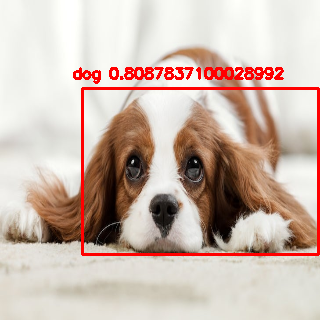

In [35]:
out = do_inference(engine, im, h_input, d_input, h_output, d_output, stream, 1, HEIGHT, WIDTH)
# cv2_imshow(img)
show_detect(img , out)